Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756304
Standard deviation: 0.454491
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Could

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

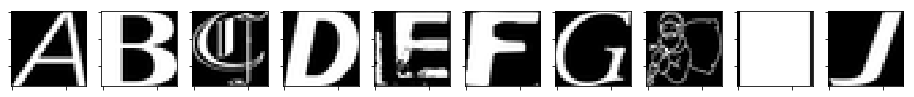

In [57]:
mapping = {1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G', 8:'H', 9:'I', 10:'J'}
fig, axes = plt.subplots(1,10, squeeze=True, figsize=(16, 9))
for k, ax in enumerate(axes.flatten()):
    images = pickle.load(open('./notMNIST_large/%s.pickle' % mapping[k+1], 'rb'))
    ax.imshow(images[np.random.randint(0, len(images))], cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

letter A has 52909 examples
letter B has 52911 examples
letter C has 52912 examples
letter D has 52911 examples
letter E has 52912 examples
letter F has 52912 examples
letter G has 52912 examples
letter H has 52912 examples
letter I has 52912 examples
letter J has 52911 examples
variance in counts for individual classes is   0.84, with min 52909.00 and max 52912.00


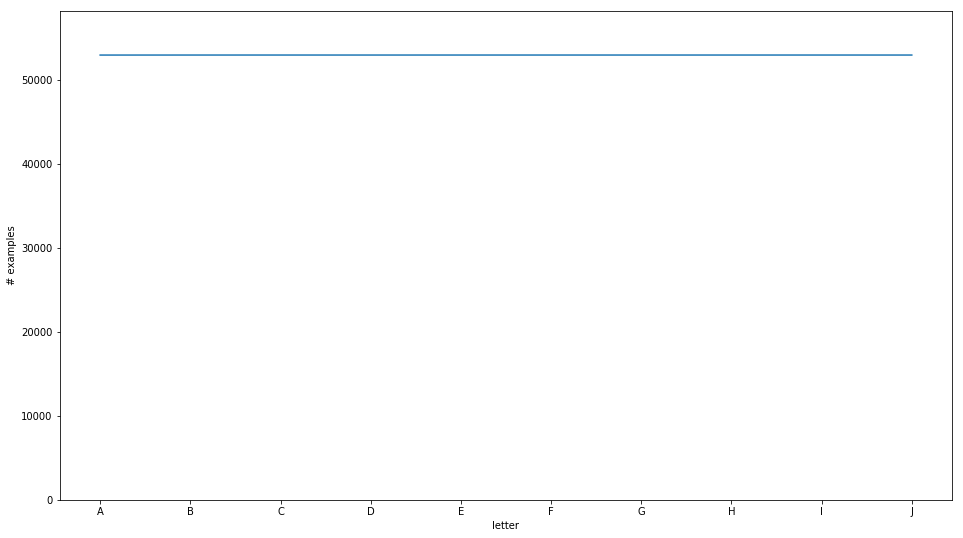

In [59]:
examples_counts = []
for k in range(1, 11):
    images = pickle.load(open('./notMNIST_large/%s.pickle' % mapping[k], 'rb'))
    print('letter %s has %d examples' % (mapping[k], len(images)))
    examples_counts.append((k, len(images)))
ec = np.array(examples_counts)
plt.plot(ec[:,0], ec[:,1])
plt.xticks(ec[:, 0], [mapping[i] for i in ec[:, 0]])
plt.xlabel('letter')
plt.ylabel('# examples')
plt.ylim(0, ec[:, 1].max()*1.1)
fig = plt.gcf()
fig.set_size_inches(16, 9)
print('variance in counts for individual classes is %6.2f, with min %6.2f and max %6.2f' % (np.var(ec[:,1]), ec[:, 1].min(), ec[:,1].max()))

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [67]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 400000
valid_size = 15000
test_size = 15000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (400000, 28, 28) (400000,)
Validation: (15000, 28, 28) (15000,)
Testing: (15000, 28, 28) (15000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [68]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

(400000, 28, 28)
(3, 20)


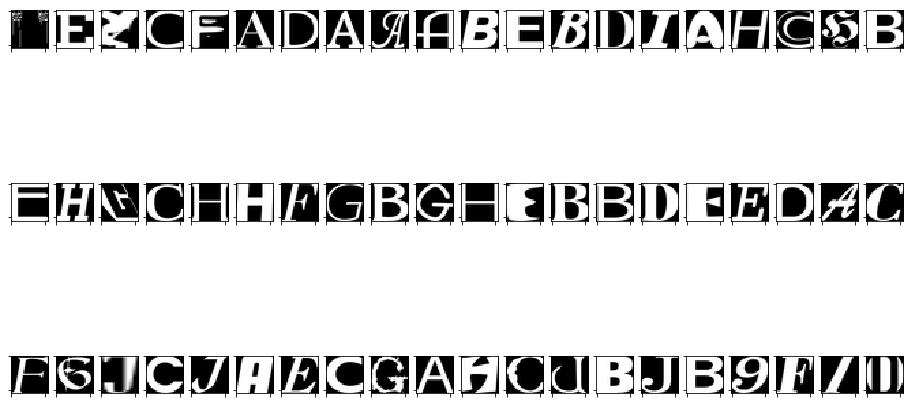

In [69]:
print(train_dataset.shape)
fig, axes = plt.subplots(3, 20, squeeze=True, figsize=(16,9))

print(axes.shape)
for ax in axes[0]:
    ax.imshow(train_dataset[np.random.randint(0, train_dataset.shape[0])], cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for ax in axes[1]:
    ax.imshow(test_dataset[np.random.randint(0, test_dataset.shape[0])], cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
for ax in axes[2]:
    ax.imshow(valid_dataset[np.random.randint(0, valid_dataset.shape[0])], cmap='gray')
    ax.set_yticklabels([])
    ax.set_xticklabels([])


Finally, let's save the data for later reuse:

In [70]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [71]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1350200512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [73]:
dataset = pickle.load(open('notMNIST.pickle', 'rb'))

#train_dataset = dataset['train_dataset']
#valid_dataset = dataset['valid_dataset']
#test_dataset = dataset['test_dataset']
overlaps_valid_test = []
overlaps_valid_train = []
overlaps_test_train = []

for k, imagek in enumerate(valid_dataset):
    for l, imagel in enumerate(test_dataset):
        if np.all(np.equal(imagek, imagel)):
            overlaps_valid_test.append([k, l])

print('there is %d overlaps between valid and test datasets' % len(overlaps_valid_test,))

for k, imagek in enumerate(valid_dataset):
    for l, imagel in enumerate(train_dataset):
        if np.all(np.equal(imagek, imagel)):
            overlaps_valid_train.append([k, l])

print('there is %d overlaps between valid and train datasets' % len(overlaps_valid_train,))

for k, imagek in enumerate(valid_dataset):
    for l, imagel in enumerate(test_dataset):
        if np.all(np.equal(imagek, imagel)):
            overlaps_test_train.append([k, l])

print('there is %d overlaps between train and test datasets' % len(overlaps_test_train,))



there is 28946 overlaps between valid and test datasets
there is 600761 overlaps between valid and train datasets
there is 28946 overlaps between train and test datasets


In [75]:
ovtest = np.array(overlaps_valid_test)
ovtrain = np.array(overlaps_valid_train)
ovtt = np.array(overlaps_test_train)



In [76]:
print('ovtest.shape', ovtest.shape)
print('ovtrain.shape', ovtrain.shape)
print('ovtt.shape', ovtt.shape)

ovtest.shape (28946, 2)
ovtrain.shape (600761, 2)
ovtt.shape (28946, 2)


In [77]:
f = open('overlaps.pickle', 'wb')
pickle.dump({'ovtest':ovtest, 'ovtrain':ovtrain, 'ovtt':ovtt}, f)
f.close()

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [4]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import time 

#clf = LogisticRegression(C=50. / train_samples,
#                         multi_class='multinomial',
#                         penalty='l1', solver='saga', tol=0.1)
#sparsity = np.mean(clf.coef_ == 0) * 100
#print("Sparsity with L1 penalty: %.2f%%" % sparsity)
target_names = list('abcdefghij'.upper())

dataset = pickle.load(open('notMNIST.pickle', 'rb'))

train_size = 400000
y_train = dataset['train_labels'][:train_size]
y_valid = dataset['valid_labels']
y_test = dataset['test_labels']

def reshape(dataset):
    a, b, c = dataset.shape
    return dataset.reshape((a, b*c))

X_train = dataset['train_dataset']
X_train = reshape(X_train)[:train_size]
X_valid = dataset['valid_dataset']
X_valid = reshape(X_valid)
X_test = dataset['test_dataset']
X_test = reshape(X_test)

clf = LogisticRegression(solver='saga', n_jobs=-1)

start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print('fit duration %.2f seconds' % (end-start,))

p_train = clf.predict(X_train)
p_valid = clf.predict(X_valid)
p_test = clf.predict(X_test)

p_train = np.array([int(a) for a in p_train])
p_valid = np.array([int(a) for a in p_valid])
p_test = np.array([int(a) for a in p_test])

print('LR train score', clf.score(X_train, y_train))
print(classification_report(p_train, y_train, target_names=target_names))
print(confusion_matrix(p_train, y_train, labels=range(len(target_names))))

print('LR valid score', clf.score(X_valid, y_valid))
print(classification_report(p_valid, y_valid, target_names=target_names))
print(confusion_matrix(p_valid, y_valid, labels=range(len(target_names))))

print('LR test score', clf.score(X_test, y_test))
print(classification_report(p_test, y_test, target_names=target_names))
print(confusion_matrix(p_test, y_test, labels=range(len(target_names))))


#sys.exit(0)

start = time.time()
try:
    classifier = pickle.load(open('SVC_pca_50components_400ktrain.pickle', 'rb'))
    clf = classifier['clf']
    pca = classifier['pca']
except:   
    pca = PCA(n_components=50)
    pca.fit(X_train)
    print('pca.components', pca.components_.shape)

    X_mod_train = pca.transform(X_train)
    print('X_mod_train.shape', X_mod_train.shape)

    clf = SVC()
    clf.fit(X_mod_train[:train_size], y_train[:train_size])
    f = open('SVC_pca_50components_400ktrain.pickle', 'wb')
    pickle.dump({'pca': pca, 'clf': clf}, f)
    f.close()
    
end = time.time()

print('fit duration %.2f seconds' % (end-start,))




p_train = clf.predict(pca.transform(X_train[:train_size]))
p_valid = clf.predict(pca.transform(X_valid))
p_test = clf.predict(pca.transform(X_test))

p_train = np.array([int(a) for a in p_train])
p_valid = np.array([int(a) for a in p_valid])
p_test = np.array([int(a) for a in p_test])

print('SVC train score', clf.score(pca.transform(X_train[:train_size]), y_train[:train_size]))
print(classification_report(p_train, y_train[:train_size], target_names=target_names))
print(confusion_matrix(p_train, y_train[:train_size], labels=range(len(target_names))))

print('SVC valid score', clf.score(pca.transform(X_valid), y_valid))
print(classification_report(p_valid, y_valid, target_names=target_names))
print(confusion_matrix(p_valid, y_valid, labels=range(len(target_names))))

print('SVC test score', clf.score(pca.transform(X_test), y_test))
print(classification_report(p_test, y_test, target_names=target_names))
print(confusion_matrix(p_test, y_test, labels=range(len(target_names))))


fit duration 555.29 seconds


NameError: name 'np' is not defined

__Logistic Regression results__


```
fit duration 535.81 seconds

LR train score 0.830207075518

*Classification report*
             precision    recall  f1-score   support

          A       0.83      0.85      0.84     38957
          B       0.80      0.86      0.83     37553
          C       0.87      0.83      0.85     41803
          D       0.86      0.85      0.85     40472
          E       0.77      0.86      0.81     35745
          F       0.87      0.84      0.86     41595
          G       0.82      0.82      0.82     39698
          H       0.84      0.84      0.84     40120
          I       0.79      0.75      0.77     42220
          J       0.85      0.81      0.83     41836

avg / total       0.83      0.83      0.83    399999

*Confusion matrix*

          [[33249   610   276   556   504   435   655  1243   798   631]
           [  597 32189   460   980   878   313   653   553   581   349]
           [  442   393 34850   383  2237   448  1748   340   559   403]
           [  572  1753   357 34298   484   379   598   636   708   687]
           [  440   963   887   326 30609   403   556   555   689   317]
           [  479   690   394   683  1274 34998   787   689   825   776]
           [  690   941  1140   584  1017   669 32668   649   772   568]
           [ 1580   751   401   592   731   498   520 33516  1072   459]
           [  937  1092   898   869  1777  1087  1009  1204 31621  1726]
           [ 1014   618   337   729   489   770   806   615  2374 34084]]


**valid**

LR valid score 0.8232
*Classification report*
             precision    recall  f1-score   support

          A       0.83      0.85      0.84      1455
          B       0.80      0.85      0.82      1419
          C       0.88      0.83      0.85      1590
          D       0.83      0.83      0.83      1490
          E       0.74      0.85      0.79      1292
          F       0.87      0.82      0.84      1589
          G       0.82      0.83      0.82      1487
          H       0.84      0.82      0.83      1544
          I       0.78      0.75      0.76      1563
          J       0.85      0.81      0.83      1571

avg / total       0.83      0.82      0.82     15000

*Confusion matrix*

          [[1244   21   13   28   19   20   29   36   22   23]
           [  25 1200   18   50   42    6   18   25   20   15]
           [  11   13 1315   16   97   26   66    9   24   13]
           [  25   71   19 1240   20   12   24   24   35   20]
           [  16   33   34   18 1104   17   20   17   24    9]
           [  21   32   10   34   55 1299   37   27   40   34]
           [  20   31   40   27   38   26 1230   23   33   19]
           [  66   29   14   29   31   23   18 1267   48   19]
           [  37   46   22   28   67   41   33   52 1169   68]
           [  35   24   15   30   27   30   25   20   85 1280]]


**test**
LR test score 0.894266666667
*Classification report*
         precision    recall  f1-score   support

          A       0.89      0.91      0.90      1453
          B       0.89      0.91      0.90      1461
          C       0.93      0.90      0.91      1559
          D       0.92      0.92      0.92      1497
          E       0.86      0.90      0.88      1421
          F       0.93      0.88      0.90      1598
          G       0.88      0.90      0.89      1457
          H       0.88      0.92      0.90      1443
          I       0.86      0.84      0.85      1533
          J       0.91      0.87      0.89      1578

*Confusion matrix*
avg / total       0.90      0.89      0.89     15000

          [[1328    8    4   11    9   11   14   39   16   13]
           [  13 1333    3   24   39    6   16   18    5    4]
           [   8    9 1399    9   43    9   53    9   10   10]
           [  11   47    3 1376    9    4   12   10   13   12]
           [  10   22   25   10 1285    6   11   22   24    6]
           [   8   19   17   16   33 1399   40   17   23   26]
           [  20   24   21    7   20    9 1313   15   17   11]
           [  45   11    5   10    7    4   10 1327   19    5]
           [  21   18   20   26   41   24   20   30 1287   46]
           [  36    9    3   11   14   28   11   13   86 1367]]

*timing results*

real	8m58.806s
user	48m48.896s
sys	3m34.252s
```


__SVM classifier with PCA features__

fit duration 10420.17 seconds

```
SVC train score 0.948665

             precision    recall  f1-score   support

          A       0.96      0.94      0.95     40644
          B       0.95      0.95      0.95     40026
          C       0.95      0.96      0.95     39503
          D       0.95      0.95      0.95     39967
          E       0.95      0.96      0.95     39306
          F       0.95      0.96      0.96     39690
          G       0.95      0.93      0.94     40872
          H       0.95      0.95      0.95     40208
          I       0.94      0.93      0.93     40277
          J       0.95      0.96      0.95     39507


avg / total       0.95      0.95      0.95    400000


          [[38252   281   205   288   245   233   235   358   289   258]
           [  215 37885   225   353   284   176   268   243   189   188]
           [  111   170 37834   105   338   128   355   135   182   145]
           [  166   404   184 38049   164   144   198   188   271   199]
           [  135   176   245   138 37831   215   158   134   163   111]
           [  152   155   134   143   234 38168   181   131   219   173]
           [  265   295   640   246   330   281 37973   266   292   284]
           [  301   243   208   203   182   199   201 38144   320   207]
           [  288   290   258   300   291   303   276   298 37434   539]
           [  115   101    67   175   101   153   155   103   641 37896]]

SVC valid score 0.9186

             precision    recall  f1-score   support

          A       0.93      0.92      0.93      1511
          B       0.91      0.91      0.91      1490
          C       0.93      0.93      0.93      1502
          D       0.91      0.92      0.91      1477
          E       0.91      0.94      0.92      1451
          F       0.93      0.93      0.93      1498
          G       0.91      0.89      0.90      1535
          H       0.93      0.91      0.92      1543
          I       0.90      0.90      0.90      1509
          J       0.92      0.93      0.93      1484

avg / total       0.92      0.92      0.92     15000


         [[1393   20    7   18   13    8    8   18   10   16]
          [  13 1359   10   40   11    8   17   12   11    9]
          [   5   11 1400    3   23    2   27   13   13    5]
          [  16   22   15 1361    9   11    8   11   12   12]
          [   4    9   15    5 1361   17   16    8   11    5]
          [   8    9    1    9   18 1397   15    4   18   19]
          [  17   18   28   21   27   12 1366   15   12   19]
          [  25   23    7   10   10   12   22 1402   24    8]
          [   8   23    9   17   21   19   17   14 1357   24]
          [  11    6    8   16    7   14    4    3   32 1383]]
          
          
SVC test score 0.967266666667

             precision    recall  f1-score   support

          A       0.97      0.98      0.97      1498
          B       0.97      0.96      0.96      1522
          C       0.97      0.98      0.97      1476
          D       0.97      0.97      0.97      1491
          E       0.96      0.97      0.97      1490
          F       0.97      0.97      0.97      1500
          G       0.96      0.96      0.96      1503
          H       0.97      0.98      0.98      1491
          I       0.95      0.95      0.95      1512
          J       0.97      0.96      0.96      1517

avg / total       0.97      0.97      0.97     15000


          [[1461    6    1    3    3    4    5    7    6    2]
           [  11 1454    2   17    9    2    8   10    7    2]
           [   0    2 1448    0   10    0    8    2    3    3]
           [   2    7    3 1453    3    3    3    1    9    7]
           [   1    5   13    3 1445    5    7    1    7    3]
           [   2    4    2    2   10 1462    6    2    5    5]
           [   4    7   22    4    4    4 1444    3    6    5]
           [  13    3    3    2    2    1    4 1459    3    1]
           [   3    9    4    8    7   13   10   11 1429   18]
           [   3    3    2    8    7    6    5    4   25 1454]]

```

*timing results*
```
real	281m53.948s
user	282m52.872s
sys	    1m12.472s
```
